# Machine Learning Engineer Nanodegree
## Capstone Project
## Predicting Ames Houses

The ultimate goal of this project is to predict how much a house should be solved in Ames, IA.
The problem is a standing [Kaggle Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The dataset contains a list of information for all houses sold in Ames, Iowa from 2006 through 2010. It contains **2930** observations and a large number of explanatory
variables (**23 nominal, 23 ordinal, 14 discrete, and 20 continuous**). Dean De Cook compiled and published this dataset in 2011 and can be found here [here](http://www.amstat.org/publications/jse/v19n3/decock.pdf). 


#### As discussed in the paper, the data is split into training and testing sets. Therefore, in the spirit of the Kaggle competition, I will work on the formats that have been processed and randomly split into 50-50 portions. The test portion is for Kaggle use. No information on SalePrice is made available. So for this development analysis, I will create the models based on the provided train.csv.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5) 
sns.set_style("white")

# Pretty display for notebooks
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

## <center> $\S$1. Load data.

In [2]:
# Load the Ames housing dataset. This will have to be split for evaluation!
data = pd.read_csv('train.csv')
# Drop id.
data = data.drop(['Id'], axis=1)

##  <center> $\S$2. Continuous Features Selection: 
### <center> Explore correlations between target and the continuous features.</center>

In [3]:
feature_continuous = []
for feature in data.columns:
    if (data[feature].dtypes == 'float64') or (data[feature].dtypes == 'int64') and (len(set(data[feature])) >= 20):
        feature_continuous.append(feature)

data_continuous =  pd.DataFrame(data, columns=feature_continuous)
data_continuous.LotArea = np.log10(data_continuous.LotArea)
data_continuous['PoolArea'] = data.PoolArea

print "There are {} continuous features to examine.".format(len(data_continuous.columns))
data_continuous.columns

There are 23 continuous features to examine.


Index([u'LotFrontage', u'LotArea', u'YearBuilt', u'YearRemodAdd',
       u'MasVnrArea', u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF',
       u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea',
       u'GarageYrBlt', u'GarageArea', u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'MiscVal',
       u'SalePrice', u'PoolArea'],
      dtype='object')

> ### Clear correlations to sale price are seen.

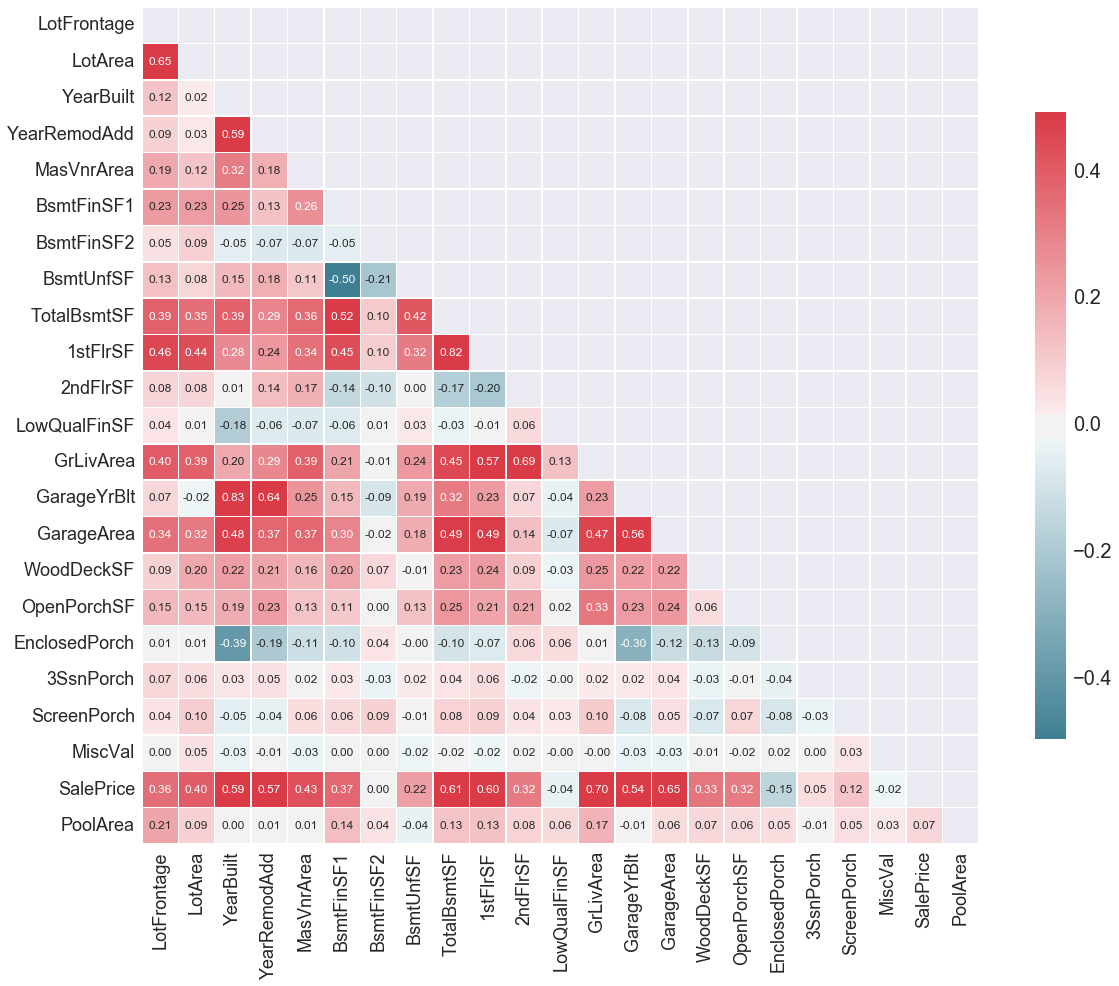

In [4]:
# Combine with SalePrice to calculate correlations.
data_continuous['SalePrice'] = np.log10(data_continuous.SalePrice)

# Compute the correlation matrix
sns.set()
corr = data_continuous.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.set_style("whitegrid")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, #xticklabels=5, yticklabels=5,
            linewidths=0.5, cbar_kws={"shrink": 0.75}, ax=ax, annot=True, fmt=".2f")
ax.tick_params(labelsize=18)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=20)
plt.savefig('PearsonCorrs.pdf', dpi=400)

## <center> $\S$3. Fitting ONLY relatively more relevant continuous variables. </center></font> 

Now that the correlations are explored, removing features weakly correlated to the Sale Price and features that are strongly correlated with other variables, we explore the performance of fitting only the continuous features. 

We also opt to work in the log-space of the Sale Price, to make the values easire to handle.

## <center> $\S$3.1. Select Features.</center></font>
 Using heat map above.

In [5]:
data_continuous = data_continuous.drop(['1stFlrSF', "2ndFlrSF", "ScreenPorch",
                                   "PoolArea", '3SsnPorch', "MiscVal", "EnclosedPorch",
                                   'BsmtFinSF2','LowQualFinSF', "BsmtUnfSF", "GarageYrBlt", 'LotFrontage'], axis=1)

## <center> $\S$3.2. Preprocessing.</center></font>
 Take care of NaNs .

In [6]:
def remove_nans(df):
    nan_df = df[pd.isnull(df).any(axis=1)]
    for col in nan_df.columns:
        tmp = nan_df[col][pd.isnull(nan_df[col])]
        if len(tmp) >= 1:
            #print "These features have NULLs to signify the absence of such a feature:"
            print col, len(tmp)
            df[col] = df[col].fillna(0.)
    print np.shape(df)
    return df

In [7]:
## Remove Nans:
data_continuous = remove_nans(data_continuous)

##  We want to separate the features from the target variable. 
y_all_cont =  data_continuous['SalePrice'] #in the log
X_all_cont =  data_continuous[data_continuous.columns[:-1]]

MasVnrArea 8
(1460, 11)


## <center><font> $\S$ 3.3. Explore model complexity. </center></font>



Explore learning curves for varying training set sizes and learning rates for GBT.

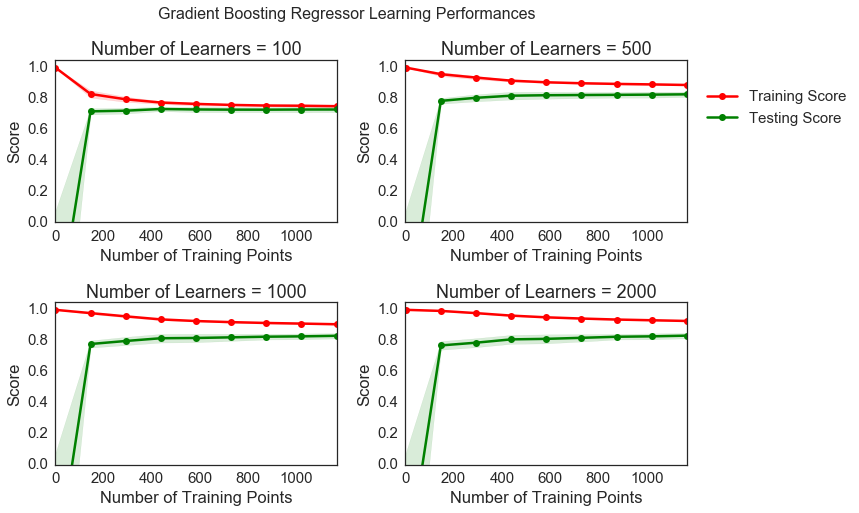

In [8]:
import visuals as vs
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")
vs.ModelLearning(X_all_cont, y_all_cont)


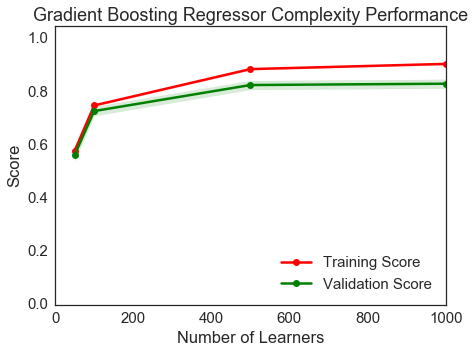

In [9]:
vs.ModelComplexity(X_all_cont, y_all_cont)

## <center><font> $\S$ 3.4. Define functions for GBT Training and scoring. </center></font>


In [10]:
# Define functions for creating sets and training.
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

############################################## Create Train/Test Splits ##############################################
############################################## Create Train/Test Splits ##############################################

def create_sets(X, y):
    # Split into training and testing components first
    from sklearn.cross_validation import train_test_split, ShuffleSplit
    
    # Set the number of training points
    num_train = int(round(0.80*len(X)))
    
    # Set the number of testing points
    num_test = X.shape[0] - num_train
    
    # Shuffle and split the dataset into the number of training and testing points above
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = num_train, random_state=123458)
    
    # Show the results of the split
    print "Training set has {} samples.".format(X_train.shape[0])
    print "Testing set has {} samples.".format(X_test.shape[0])
    return X_train, X_test, y_train, y_test

##############################################   Model   Fitting   ##############################################
##############################################   Model   Fitting   ##############################################

# Using GridSearch CV, we fine tune the model.

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.grid_search import GridSearchCV


def fit_model(X, y, n_estimators = 1000, min_samples_leaf = 1, min_samples_split =2):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20)
    regressor = GradientBoostingRegressor(n_estimators=n_estimators,min_samples_leaf = 1, 
                                          min_samples_split =2,random_state=102345)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'learning_rate': [0.01, 0.02, 0.05, 0.1], # 'n_estimators': [100, 500, 1000],
              'max_depth': [2, 3, 4, 6], 'min_samples_leaf':  [2,3,5,9,17]}
    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)
    # Create the grid search object
    grid = GridSearchCV(regressor, params, cv=cv_sets, scoring = scoring_fnc)#, verbose=10)
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X_train, y_train)
    # Print the optimal model after fitting the data
    print 'The cross-validation scores = {:.2f}'.format(grid.best_score_)
    print grid.best_estimator_
    return grid

## <center> $\S$3.5. Begin training. 
Training with only relatively more relevant  continuous features.

In [11]:
## Begin training, and print out some performance metrics.
X_train, X_test, y_train, y_test = create_sets(X_all_cont, y_all_cont)
reg = fit_model(X_train, y_train, n_estimators=1000, min_samples_leaf = 1, min_samples_split =2)
pred = reg.predict(X_test)
    
print 'The R$^2$ = {:.2f}'.format(r2_score(pred, y_test))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred, y_test))


Training set has 1168 samples.
Testing set has 292 samples.
The cross-validation scores = 0.84
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.05, loss='ls',
             max_depth=2, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=102345, subsample=1.0, verbose=0,
             warm_start=False)
The R$^2$ = 0.81
The  RMSE = 4.57e-03.


### Some preliminary results:

> ### With outliers and ONLY using the (roughly independent and relatively more significant) continuous features, gBoost with GridSearchCV gives :

> + learning_rate = 0.03, max_depth = 2, n_estimators = 1000, min_samples_leaf=4, min_samples_split=2

> ### yielding an R$^2$ = 0.82 and a scaled RMSE =4.13$\times$ 10 $^{-3}$.

> The decision tree regressor yields R$^2$ $\approx$ 0.6

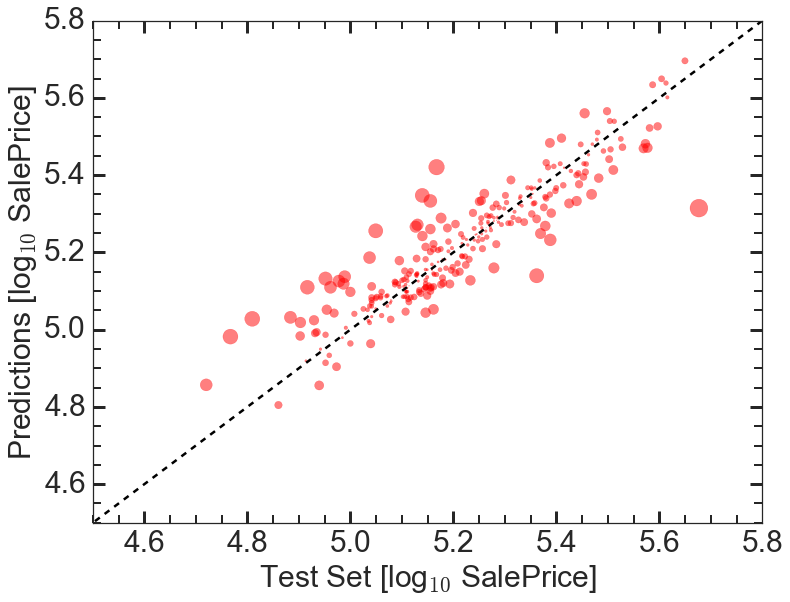

In [12]:
## Visualize the results.
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9

plt.scatter(y_test, pred,  alpha = 0.5, s = 5000*np.abs(y_test-pred)/y_test, color = 'red')
plt.xlim(4.5,5.8)
plt.ylim(4.5,5.8)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.plot(np.arange(0,10, 0.1), np.arange(0,10, 0.1), 'k--')
plt.xlabel('Test Set [log$_{10}$ SalePrice]', fontsize=30)
plt.minorticks_on()
#plt.tight_layout()
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.ylabel('Predictions [log$_{10}$ SalePrice]', fontsize=30);
plt.savefig('Cont_features_reg.pdf', dpi=200)

### <center> $\S$3.6 What is the effect of REPEAT outliers? 
See if improvement on fit is achieved. Repeat outliers are those examples/entries that have more than one "abnormal" features, as defined via Turkey's rule.

### Using [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal. 

$\therefore$ We remove all these outliers to investigate if a more robust regression results.

In [13]:
# For each feature find the data points with extreme high or low values
def remove_outliers(df):
    outliers  = []
    out_columns = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 
                   'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']
    for feature in out_columns:
        
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(df[feature], 25)
        
        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(df[feature], 75)
        
        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3-Q1)
        
        outliers = list(outliers + df[~((df[feature] >= Q1 - step) & \
                                                  (df[feature] <= Q3 + step))].index.tolist())
    
    # Select the indices for data points you wish to remove
    from collections import Counter
    counts = Counter(outliers)
    outliers = sorted([value for value, count in counts.items() if count > 1])
    return outliers

In [14]:
# Remove the outliers, if any were specified
outliers = remove_outliers(data_continuous)
good_data = data_continuous.drop(data_continuous.index[outliers]).reset_index(drop = True)

y_all_cont =  data_continuous['SalePrice']
good_data_X = good_data[good_data.columns[:-1]]
good_data_y =  good_data[good_data.columns[-1]]
print "The dimensions of the data without repeat outliers now is {}".format(np.shape(good_data))

The dimensions of the data without repeat outliers now is (1387, 11)


### <center> $\S$3.6.1  Now, training GOOD data ONLY

In [15]:
#from sklearn.preprocessing import min_max_scaler
X_train, X_test, y_train, y_test = create_sets(good_data_X, good_data_y)
reg = fit_model(X_train, y_train, n_estimators=1000, min_samples_leaf = 1, min_samples_split = 10)
pred = reg.predict(X_test)
    
print 'The R$^2$ = {:.2f}'.format(r2_score(pred, y_test))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred, y_test))

Training set has 1110 samples.
Testing set has 277 samples.
The cross-validation scores = 0.85
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=3, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=102345, subsample=1.0, verbose=0,
             warm_start=False)
The R$^2$ = 0.80
The  RMSE = 4.06e-03.


### $\S$3.6 Conclusion 

> ### Removing outliers did not help much!


## <center> $\S$4. Now, we consider the non-continuous features.
> ## Exploration is in the other notebook. Conclusion:

## <center> $\S$4.1 Load data and extract relevant columns.


In [16]:
## Start with a clean slate.
data = pd.read_csv('train.csv')
data_new = data.copy()

### Extract all non-continuous variables

columns_noncont = ["MSZoning", "Neighborhood", "Condition1",
                   "OverallQual","RoofStyle","OverallCond","ExterQual","Foundation", "HeatingQC", 'KitchenQual', 
                   #"HouseStyle",
                   "BsmtQual", "FullBath", "BedroomAbvGr", "TotRmsAbvGrd","Fireplaces", "GarageType", #"MasVnrType",
                   "PoolQC","GarageCars","GarageQual","PavedDrive", "Heating",  "GarageCond", "SaleCondition"]

columns_all = columns_noncont + list(X_all_cont.columns) + ['SalePrice']  #","CentralAir","
data_all = data_new[columns_all]
X_all_cont.columns

Index([u'LotArea', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea', u'BsmtFinSF1',
       u'TotalBsmtSF', u'GrLivArea', u'GarageArea', u'WoodDeckSF',
       u'OpenPorchSF'],
      dtype='object')

## <center> $\S$4.2 Prepocessing.

In [17]:
# Remove NaNs
data_all = remove_nans(data_all)

# Remove Outliers
outliers = remove_outliers(data_continuous)
good_data = data_all.drop(data_all.index[outliers]).reset_index(drop = True)
good_data_X = good_data[good_data.columns[:-1]]
good_data_y =  good_data[good_data.columns[-1]]
print "The dimensions of the data without outliers now is {}".format(np.shape(good_data_X))

BsmtQual 37
GarageType 81
PoolQC 1453
GarageQual 81
GarageCond 81


/Users/gmsardane/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MasVnrArea 8
(1460, 34)
The dimensions of the data without outliers now is (1387, 33)


### 4.2.3 Preprocess Categorical Feature Columns

There are several non-numeric columns that need to be converted! Some of them are simply are of an **either-or** type. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Alley` and `Street`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. 
The code cell below to perform the preprocessing routine discussed in this section.

In [18]:
#Make dummies for categorical features.
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'GarageCond' => 'GarageCond_Ex', etc.
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

In [19]:
X_all = preprocess_features(good_data_X)
y_all = good_data_y
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(sorted(X_all.columns)))
print np.shape(X_all)

Processed feature columns (123 total features):
['BedroomAbvGr', 'BsmtFinSF1', 'BsmtQual_0.0', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'Fireplaces', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'FullBath', 'GarageArea', 'GarageCars', 'GarageCond_0.0', 'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Po', 'GarageCond_TA', 'GarageQual_0.0', 'GarageQual_Ex', 'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_Po', 'GarageQual_TA', 'GarageType_0.0', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GrLivArea', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'He

## <center> $\S$5. Training on the entire selected features set.
Training 37 features dummied into 123 features without chronic OUTLIERS. </center></font>

## <center> $\S$5.1. Training  in LINEAR space.

In [20]:
X_train, X_test, y_train, y_test = create_sets(X_all, good_data_y)
reg = fit_model(X_train, y_train, n_estimators=1000, min_samples_leaf = 1, min_samples_split = 10)
pred = reg.predict(X_test)
    
print 'The R$^2$ = {:.2f}'.format(r2_score(pred, y_test))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred, y_test))

Training set has 1110 samples.
Testing set has 277 samples.
The cross-validation scores = 0.92
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.05, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=2, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=102345, subsample=1.0, verbose=0,
             warm_start=False)
The R$^2$ = 0.87
The  RMSE = 5.30e+08.


## Visualizations

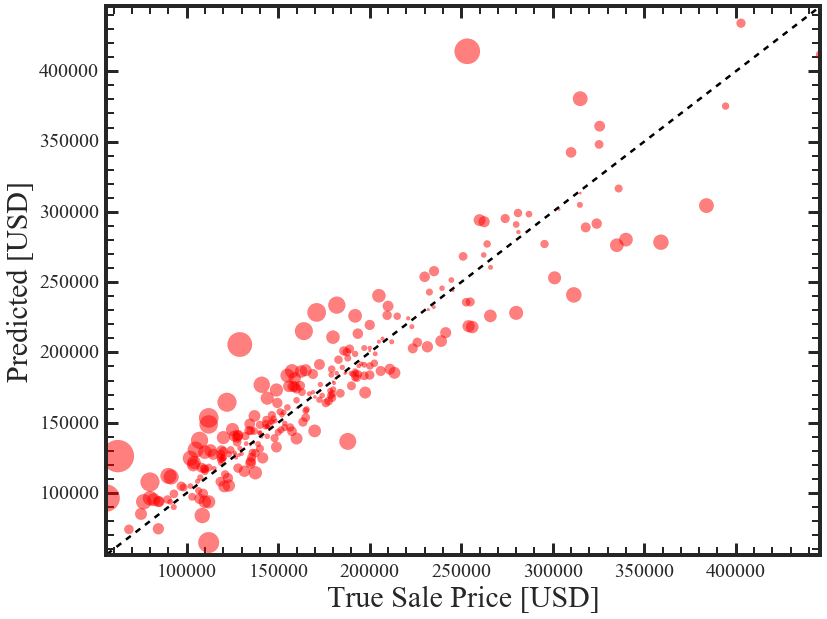

In [21]:
plt.scatter(y_test, pred, alpha = 0.5, s = 1000*np.abs(y_test-pred)/y_test, color = 'red')
plt.xlabel("True Sale Price [USD]", fontsize = 30);
plt.ylabel(r"Predicted [USD]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.plot(np.arange(0,1000000, 100000), np.arange(0,1000000, 100000), 'k--')
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_test), min(pred)]), max([max(y_test), max(pred)]))
plt.ylim(min([min(y_test), min(pred)]), max([max(y_test), max(pred)]))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("FinalModel_linear.pdf")

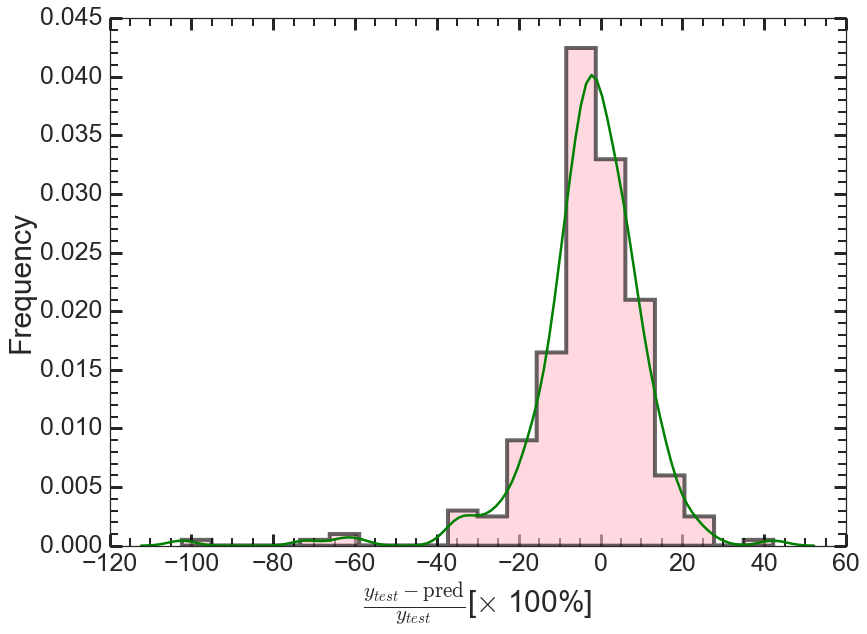

In [22]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
diff = (y_test - pred)/y_test*100.
sns.distplot(diff, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - \mathrm{pred} }{y_{test}}$" + r"[$ \times $ 100%]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.savefig('FinalDiffDist_linear.pdf')

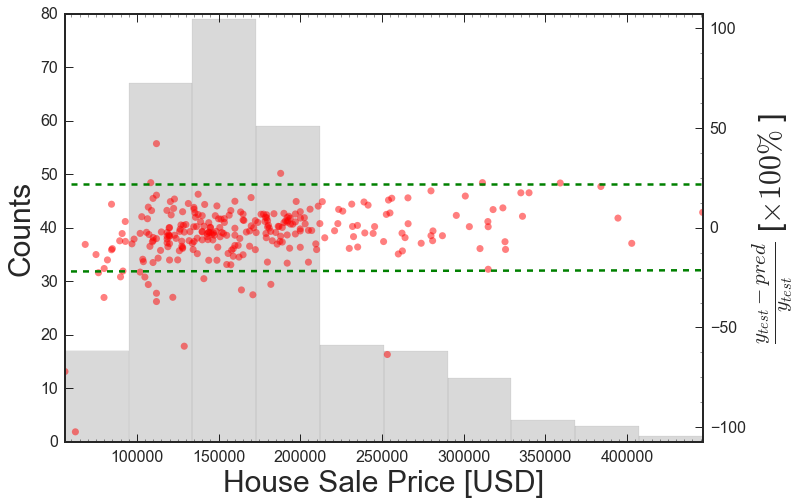

In [23]:
#SECONDARY AXIS WITH COLOR BAR

from scipy import stats

fig = plt.figure()#, figsize=(6,6))
gs = grd.GridSpec(2, 1, height_ratios=[1,15], width_ratios=[20,1], wspace=0.1)

# Set minor tickmarks
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.

# Primary plot
ax1 = plt.subplot(gs[1])
ax1.hist(y_test, color = ["black"], alpha=0.15)

plt.xlabel(r'House Sale Price [USD]', size=30)
plt.ylabel('Counts', size = 30)


#Secondary AXIS
ax2 = ax1.twinx()
ax2.xaxis.set_minor_locator(minorLocatorx)
ax2.yaxis.set_minor_locator(minorLocatory)

ax2.scatter(y_test, diff,  edgecolor= 'none', s=50, c='red', alpha=0.5)
ax2.set_ylabel(r"$\frac{y_{test} - pred }{y_{test}}$" + r" [$\times 100\% $ ]", fontsize = 30);

plt.plot([0, 1e8], [2*np.std(np.abs(diff)),2*np.std(np.abs(diff))], color = 'green', linestyle = '--')
plt.plot([0, 1e8], [-2*np.std(np.abs(diff)),12*np.std(np.abs(diff))], color = 'green', linestyle = '--')
plt.ylim(min(diff)-5, max(np.abs(diff))+5)
plt.xlim(min(y_test), max(y_test));
plt.savefig('Residuals_linear.pdf')

## <center> $\S$5.1. Evaluation Kaggle's log RMSE.

In [24]:
np.sqrt(np.sum((np.log(y_test +1) - np.log(pred+1))**2)/len(y_test))

0.12904587663637085

# <center> $\S$5.2. Fitting in the LOG$_{10}$ - space </center></font>

## Visualizations

The R$^2$ = -7.50
The  RMSE = 3.50e+10.


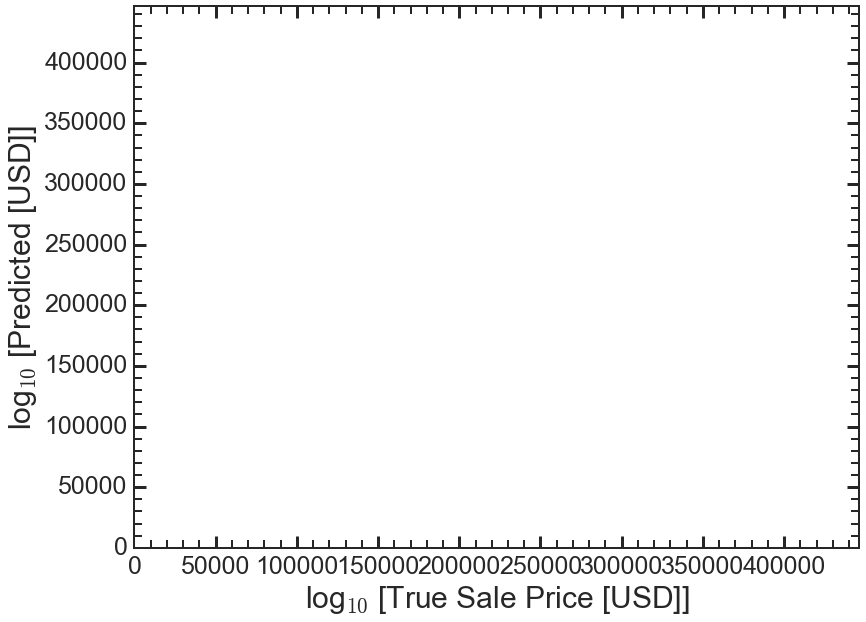

In [26]:
plt.scatter(y_test_log, pred_log10, alpha = 0.5, s = 5000*np.abs(10**y_test_log-10**pred_log10)/10**y_test_log, color = 'red' );
plt.xlabel(r"log$_{10}$ [True Sale Price [USD]]", fontsize = 30);
plt.ylabel(r"log$_{10}$ [Predicted [USD]]", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.xlim(min([min(y_test_log), min(pred_log10)]), max([max(y_test), max(pred_log10)]))
plt.ylim(min([min(y_test_log), min(pred_log10)]), max([max(y_test), max(pred_log10)]))
plt.plot(np.arange(0,10, 0.1), np.arange(0,10, 0.1), 'k--')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig("FinalModel_log.pdf")
print 'The R$^2$ = {:.2f}'.format(r2_score(pred_log10,y_test_log))
print 'The  RMSE = {:.2e}.'.format(mean_squared_error(pred_log10, y_test_log))

In [27]:
print "The RMSE for the TEST sample is {:0.2e}.".format(mean_squared_error(10**pred_log10, 10**y_test_log))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
diff = (10**y_test_log - 10**reg_log10.predict(X_test_log))/10**y_test_log*100.
sns.distplot(diff, bins=20, color='g', hist_kws={"histtype": "stepfilled", "linewidth": 4, 
                                                    "alpha": 0.60, "color": "pink"});
plt.xlabel(r"$\frac{y_{test} - pred }{y_{test}}$" + r" [$\times 100\% $ ]", fontsize = 30);
plt.ylabel(r"Frequency", fontsize = 30);
plt.minorticks_on()
plt.tight_layout()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.tick_params('both', length=8, width=2, which='minor');
plt.tick_params('both', length=12, width=3, which='major');
plt.savefig('FinalDiffDist_log.pdf')

In [ ]:
#SECONDARY AXIS WITH COLOR BAR

from scipy import stats

fig = plt.figure()#, figsize=(6,6))
gs = grd.GridSpec(2, 1, height_ratios=[1,15], width_ratios=[20,1], wspace=0.1)

# Set minor tickmarks
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.

# Primary plot
ax1 = plt.subplot(gs[1])
ax1.hist(10**y_test, color = ["black"], alpha=0.15)

plt.xlabel(r'House Sale Price [USD]', size=30)
plt.ylabel('Counts', size = 30)


#Secondary AXIS
ax2 = ax1.twinx()
ax2.xaxis.set_minor_locator(minorLocatorx)
ax2.yaxis.set_minor_locator(minorLocatory)

ax2.scatter(10**y_test_log, diff,  edgecolor= 'none', s=50, c='red', alpha=0.5)
ax2.set_ylabel(r"$\frac{y_{test} - pred }{y_{test}}$" + r" [$\times 100\% $ ]", fontsize = 30);

plt.plot([0, 1e8], [2*np.std(np.abs(diff)),2*np.std(np.abs(diff))], color = 'green', linestyle = '--')
plt.plot([0, 1e8], [-2*np.std(np.abs(diff)),12*np.std(np.abs(diff))], color = 'green', linestyle = '--')
plt.ylim(min(diff), max(diff))
plt.xlim(min(10**y_test_log), max(10**y_test_log));
plt.savefig('Residuals_log.pdf')

In [ ]:
print 'The mean DIFF is {:0.2f} and the std {:0.2f}'. format(np.mean(diff), np.std(diff))